In [1]:
import pandas as pd
import numpy as np
import os
from os import path
import shutil
import matplotlib.pyplot as plt
import re
import traceback
%matplotlib inline

In [2]:
# focus on three regions now
regions = [
    "Burgenland",
    "Kärnten",
    "Niederösterreich",
    "Oberösterreich",
    "Salzburg",
    "Steiermark",
    "Tirol",
    "Vorarlberg",
    "Wien"
]
region_dirs = ["/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_{}_gw_{}".format(num, regions[idx]) for idx, num in enumerate(range(1, len(regions)+1))]
region_dirs

['/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_1_gw_Burgenland',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_2_gw_Kärnten',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_3_gw_Niederösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_4_gw_Oberösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_6_gw_Steiermark',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_7_gw_Tirol',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_8_gw_Vorarlberg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_9_gw_Wien']

## Measuring point data with regions

In [3]:
def get_num_from_str(string):
    matches = re.findall(r"\d+\.\d+", string)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_mp_attrs(region, region_dir, mp_num):

    mp_base_data_path = path.join(region_dir, "Stammdaten", "Stammdaten-{0}.txt".format(mp_num))
    
    land_height = np.nan
    mp_height = np.nan
    bottom_line = np.nan
    t_measuring_depth = np.nan
    
    with open(mp_base_data_path, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if "Geländehöhe" in line:
                land_height = get_num_from_str(line)
                
            elif "Messpunkthöhe" in line:
                mp_height = get_num_from_str(line)
                
            elif "Sohllage" in line:
                bottom_line = get_num_from_str(line)
                
            elif "T-Messtiefe u.GOK" in line:
                t_measuring_depth = get_num_from_str(line)
                
                break # since it's always listed latest in the file
    
    mp = {
        "land_height": land_height,
        "mp_height": mp_height,
        "bottom_line": bottom_line,
        "t_measuring_depth": t_measuring_depth
    }
    
    return mp

# test
region_idx = 0

# try mp with full attr
mp_num = 305540
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

# try mp with missing attr -> np.nan in missed value
mp_num = 300137
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

mp 305540 attrs: {'land_height': '120.68', 'mp_height': '120.88', 'bottom_line': '114.98', 't_measuring_depth': '5.60'}
mp 300137 attrs: {'land_height': '154.76', 'mp_height': '154.76', 'bottom_line': '151.36', 't_measuring_depth': nan}


In [4]:
values = []

for i in range(len(regions)):
    region = regions[i]
    region_dir = region_dirs[i]
    # mps: measurment points 
    df_mps_path = path.join(region_dir, "messstellen_alle.csv")
    df_mps = pd.read_csv(df_mps_path, sep=";")
    # filter to typ == 'gw' then del typ col
    df_mps = df_mps.query("typ=='gw'")
    del df_mps["typ"]
    
    df_mps["region"] = region
    
    # for every mp in the region get attributes
    # create attrs cols and init with np.nan
    mp_attrs = ["land_height", "mp_height", "bottom_line", "t_measuring_depth"]
    for mp_attr in mp_attrs:
        df_mps[mp_attr] = np.nan
    
    # fill with values when available
    for index, row in df_mps.iterrows():
        mp_num = row["hzbnr01"]
        mp_attr_vals = get_mp_attrs(region, region_dir, mp_num = mp_num)
        for mp_attr in mp_attrs:
            df_mps.at[index, mp_attr] = float(mp_attr_vals[mp_attr])
    
    values.extend(df_mps.values.tolist())

colnames = ["x", "y", "dbmsnr", "hzbnr01", "region"] + mp_attrs
df_mps_all = pd.DataFrame(values, columns = colnames)
df_mps_all["x"] = df_mps_all["x"].str.replace(",", ".").astype(float)
df_mps_all["y"] = df_mps_all["y"].str.replace(",", ".").astype(float)

df_mps_all

,x,y,dbmsnr,hzbnr01,region,land_height,mp_height,bottom_line,t_measuring_depth
0,679020.30,448967.00,1002266,335588,Burgenland,125.76,126.66,108.29,NaN
1,643311.78,398158.79,1002285,335810,Burgenland,235.69,236.59,225.74,10.00
2,616039.28,341145.21,1002422,345876,Burgenland,234.06,234.86,228.06,NaN
3,615420.17,341879.22,1002237,335299,Burgenland,238.18,238.28,233.38,NaN
4,665124.60,430698.99,1002327,345256,Burgenland,116.99,117.54,114.65,NaN
...,...,...,...,...,...,...,...,...,...
3786,631609.35,485861.88,9002133,319749,Wien,157.12,157.07,142.07,NaN
3787,622685.15,480101.35,9002268,350074,Wien,187.09,187.94,175.89,NaN
3788,633723.06,481067.86,9002260,350116,Wien,160.93,161.93,150.93,NaN
3789,633459.50,482115.68,9002231,341438,Wien,154.76,155.71,145.15,6.05


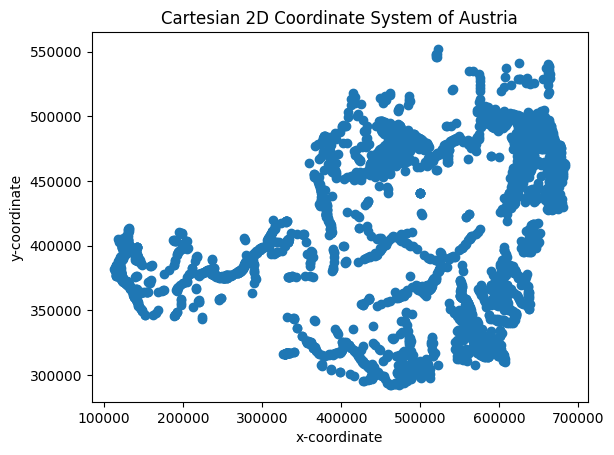

In [5]:
plt.scatter(df_mps_all["x"], df_mps_all["y"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Cartesian 2D Coordinate System of Austria")
plt.show()

In [6]:
sub_path = "/users/azeez/water_prediction/ai4ls_2_water_prediction/data/processed/gw_test_empty.csv"
submission_df = pd.read_csv(sub_path)
test_ids = submission_df.columns[1:]

In [7]:
# define radius for measuring point within neighbouring temperature points

def find_temp_mps_in_radius(region, df_mps_all, temp_mps, hzbnr01, radius):

    # get mp coordiantes
    c_x = df_mps_all.query('hzbnr01==@hzbnr01').iloc[0]["x"]
    c_y = df_mps_all.query('hzbnr01==@hzbnr01').iloc[0]["y"]

    # find all mps in radius
    x_min = c_x - radius
    x_max = c_x + radius
    y_min = c_y - radius
    y_max = c_y + radius
    df_mps_rds = df_mps_all.query('(@x_min <= x <= @x_max) & (@y_min <= y <= @y_max)')
    
    # get the temp mps in the radius dataframe
    df_temp = df_mps_rds[df_mps_rds["hzbnr01"].isin(temp_mps)]
    
    return df_temp["hzbnr01"].tolist()


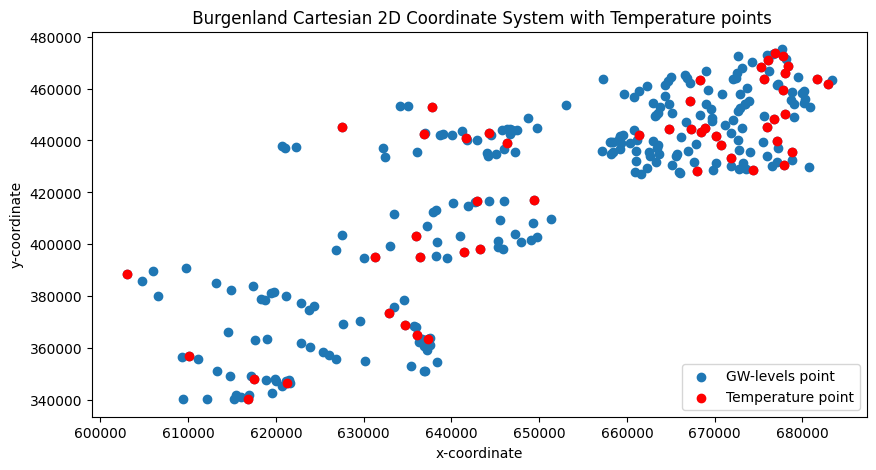

In [10]:
# Get all the groundwater temperature hzhnr01
burg = df_mps_all[df_mps_all["region"]=="Burgenland"]

burg_temp_dir = region_dirs[0] + "/Grundwassertemperatur-Monatsmittel" 
filenames = os.listdir(burg_temp_dir)
mps = []
for file in filenames:
    loc_id = file.split(".")[0].split("-")[-1]
    mps.append(int(loc_id)) 
burg_temp_df = burg[burg["hzbnr01"].isin(mps)]

# Plot the temperature points areas with the groundwater locations in Burgenland
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(burg["x"], burg["y"], label="GW-levels point")
plt.scatter(burg_temp_df["x"], burg_temp_df["y"], color="r", label="Temperature point")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.legend(loc="lower right")
plt.title(" Burgenland Cartesian 2D Coordinate System with Temperature points")
plt.show()

## Preprocess Temperature and Groundwater level

In [9]:
# know how many rows to skip in pd.read_csv
def csv_find_skiprows(filepath, lookup):
    skiprows = 0
    # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
    with open(filepath, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if lookup in line:
                skiprows = num
                # print("skiprows:", skiprows)
                break
                
    return skiprows

def process_region_sub_dir(region, region_dir, df_mps, folder_name, val_col_name, radius=20000, debugging=False):
    """ Function to preprocess monthly groundwater and temperature values for all nine regions
    Input:
        region(string): name of the region

        region_dir(filepath): directory file path to the region

        df_mps(df): dataframe for all the measuring points for all the 9 regions

        folder_name(string): name of the groundwater folder

        val_col_name(string): groundwater level value column

        radius(int): radius range to search for temperature if the measuring point ID doesn't have a corresponding temp

        debugging(bool): process all files or not
    
    Output:
        None
    """

    index = region_dir.find("/raw/")
    
    outward_dir = region_dir[:index + len('/raw/')]
    
    folder_dir = path.join(region_dir, folder_name)
    
    print("> Processing {} - {}..".format(region, folder_name))
    
    # clean previous processing output
    output_dir = path.join(folder_dir, "temp_processed_data")

    outward_dir = path.join(outward_dir, "temp_processed_data")
    
    if not path.exists(outward_dir): 
        os.mkdir(outward_dir)
        
    try:
        shutil.rmtree(output_dir)
    except:
        pass
    os.mkdir(output_dir)
    
    filenames = os.listdir(folder_dir)
    for filename in filenames:

        mp_num = filename.split(".")[0].split("-")[-1]

        if mp_num not in test_ids:
            continue
        
        filepath = path.join(folder_dir, filename)
        
        # process only files (don't iterate over output dir)
        if not path.isfile(filepath):
            continue
        
        # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
        lookup = "Werte:"
        skiprows = csv_find_skiprows(filepath, lookup)
        
        # load and process .csv file
     
        df = pd.read_csv(filepath, sep=" ;", header=None, skiprows=skiprows,
                               encoding='unicode_escape')
        

        # manipulate data splitting values into more possible regressors (e.g. date -> day, month, year)
        df.columns = ["date", val_col_name, "empty"]
        del df["empty"] 
        
        df["date"] = pd.to_datetime(df["date"].str.strip(), format='%d.%m.%Y %H:%M:%S')
        df.set_index("date", inplace=True)
        datetime_seq = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

       
        #if len(df) != len(datetime_seq):
        df2 = pd.DataFrame(datetime_seq, columns=["date"])
        
        # Use boolean indexing to assign values
        for date in datetime_seq:
            if date in df.index:
                value =  df.loc[date, val_col_name]
                df2.loc[df2['date'] == date, val_col_name] = value.replace(",",".") if "Lücke" not in value else value
            else:
                df2.loc[df2['date'] == date, val_col_name] = np.nan
    
        # Use regex to handle variations of "Lücke"
        regex_pattern = r'\bLücke\b' 
    
        # Replace variations of "Lücke" with NaN
        df2[val_col_name] = df2[val_col_name].astype(str).replace(regex_pattern, np.nan, regex=True)
    
        # Convert to float and handle NaN interpolation
        df2[val_col_name] = pd.to_numeric(df2[val_col_name], errors='coerce')
        df2[val_col_name] = df2[val_col_name].interpolate(method="linear")
        df2[val_col_name] = df2[val_col_name].round(2)
        
        # remove the last year 2022-01-01 on the date column
        last_date = df2['date'].max()
        if '2022-01-01' in str(last_date):
            df2 = df2.iloc[:-1]
        df = df2

        # # add more time series for test data
        last_date = df["date"].max()
        new_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=26, freq='MS')

        # Create a DataFrame with the new dates
        new_data = pd.DataFrame({"date": new_dates})
        df = pd.concat([df, new_data], ignore_index=True)

        # add temperature
        df_mps_region = df_mps[df_mps["region"]==region]
        region_temp_dir = region_dir + "/Grundwassertemperatur-Monatsmittel" 
        region_temp_filenames = os.listdir(region_temp_dir)
        
        temp_mps = []
        for file in region_temp_filenames:
            loc_id = file.split(".")[0].split("-")[-1]
            temp_mps.append(int(loc_id)) 

        if int(mp_num) in temp_mps:
            temp_num_id = mp_num
        else:
            # Set 20,000 radius around the measuring point area
            hzhnr01 = int(mp_num)
            rds_temp_loc = find_temp_mps_in_radius(region, df_mps_region, temp_mps, hzhnr01, radius)
        
            # randomly selecta temperature area
            temp_num_id = str(np.random.choice(rds_temp_loc))

        mnth_temp_fpath = path.join(region_dir, "Grundwassertemperatur-Monatsmittel/" "Grundwassertemperatur-Monatsmittel-{0}.csv".format(temp_num_id))

        skiprows = csv_find_skiprows(mnth_temp_fpath, lookup)
        
        # load and process .csv file
        df_temp = pd.read_csv(mnth_temp_fpath, sep=" ;", header=None, skiprows=skiprows,
                               encoding='unicode_escape') 
        
        df_temp.columns = ["date", "temp", "empty"]
        del df_temp["empty"] 

        # remove rows with gaps ("Lücke")
        df_temp = df_temp[~df_temp["temp"].str.contains("Lücke")]
        
        df_temp["date"] = pd.to_datetime(df_temp["date"].str.strip(), format='%d.%m.%Y %H:%M:%S')

        # Create a dictionary for quick lookup
        temp_dict = df_temp.set_index("date")["temp"].to_dict()
        
        # Fill in temp values based on date
        df["temp"] = df["date"].map(temp_dict)
        
        # Convert temp column to numeric and handle commas
        df["temp"] = pd.to_numeric(df["temp"].str.replace(",", "."), errors='coerce')
        df["temp"] = df["temp"].interpolate(method="linear")
        df["temp"] = df["temp"].fillna(df["temp"].mean())
        df["temp"] = df["temp"].round(2)

        # Set the last 26 entries of the 'temp' column to NaN
        df.loc[df.index[-26:], 'temp'] = np.nan
        df.set_index("date", inplace=True)

        # save processed data to file
        out_filename = "processed_{}".format(filename)
        file_path = path.join(output_dir, out_filename)
        df.to_csv(file_path)
        
        # Copy the file to outward_dir
        new_filename = out_filename.replace("processed_Grundwasserstand-Monatsmittel", region)
        new_filepath = os.path.join(outward_dir, new_filename)
        shutil.copy(file_path, new_filepath)
        
        # if debugging, process only one file from each sub dir 
        if debugging:
            break
        
    print("\t- Done!")

    return None

In [10]:
def process_region_files(region, region_dir, df_mps, test_ids):
    
    # process and manipulate region files into clean .csv files
    FILE_PROCESSING_DEBUGGING = False # False => process  all files     
    folder_name = "Grundwasserstand-Monatsmittel"
    val_col_name = "gw-level"
    
    process_region_sub_dir(region, region_dir, df_mps, folder_name, val_col_name, debugging=FILE_PROCESSING_DEBUGGING)

In [11]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for i in range(9):
        region_idx = i
        region = regions[region_idx]
        region_dir = region_dirs[region_idx]
        process_region_files(region, region_dir, df_mps_all, test_ids)

> Processing Burgenland - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Kärnten - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Niederösterreich - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Oberösterreich - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Salzburg - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Steiermark - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Tirol - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Vorarlberg - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Wien - Grundwasserstand-Monatsmittel..
	- Done!
